In [13]:
# importing libraries 
import os 
import cv2  
from PIL import Image  
  
# Video Generating function 
def generate_video(image_folder='.'): 
    video_name = os.path.join(image_folder, f'video.avi')
      
    images = [img for img in os.listdir(image_folder) 
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")] 
     
    # Array images should only consider 
    # the image files ignoring others if any 
    print(images)  
    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")], key=lambda x: int(x.split('.')[0]))
    print(images)  
  
    frame = cv2.imread(os.path.join(image_folder, images[0])) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height))  
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(os.path.join(image_folder, image)))  
      
    video.release()  # releasing the video generated 
  
  
# Calling the generate_video function 
generate_video(image_folder='data/out1')

['49.png', '38.png', '12.png', '6.png', '26.png', '40.png', '11.png', '21.png', '42.png', '16.png', '24.png', '59.png', '64.png', '17.png', '30.png', '53.png', '7.png', '65.png', '8.png', '67.png', '3.png', '29.png', '61.png', '9.png', '56.png', '63.png', '20.png', '48.png', '32.png', '35.png', '43.png', '2.png', '45.png', '62.png', '66.png', '10.png', '23.png', '55.png', '15.png', '36.png', '1.png', '4.png', '13.png', '57.png', '33.png', '5.png', '51.png', '44.png', '39.png', '54.png', '46.png', '47.png', '37.png', '0.png', '31.png', '60.png', '50.png', '25.png', '22.png', '34.png', '14.png', '52.png', '18.png', '28.png', '58.png', '19.png', '41.png', '27.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png'

In [17]:
import numpy as np
import cv2

def decay(accumulator, decay_const):
    return accumulator / decay_const

def rejuvenate(fgmask, accumulator, rejuvenate_const):
    fgmask = np.where(fgmask > 0, 1, 0)
    fgmask = np.stack((fgmask,) * 3, axis=-1)
    return np.maximum(accumulator, fgmask * rejuvenate_const)

def process_video(input_file='input_video.mp4', output_file='out.mp4', output=False, decay_rate=1.01):
    video = cv2.VideoCapture(input_file)
    if not video.isOpened():
        print("Ошибка при открытии видеофайла.")
        return
    
    frame_shape = (int(video.get(4)), int(video.get(3)), 3)
    decay_const = np.full(frame_shape, [decay_rate, 1, 1])
    rejuvenate_const = np.full(frame_shape, [179, 225, 225])
    accumulator = np.full(frame_shape, [0, 225, 225])
    
    bg_subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()
    
    frames = []
    
    while video.isOpened():
        try:
            ok, frame = video.read()
            if not ok:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            fgmask = bg_subtractor.apply(gray)
            accumulator = decay(accumulator, decay_const)
            accumulator = rejuvenate(fgmask, accumulator, rejuvenate_const)
            frame = cv2.cvtColor(accumulator.astype(np.uint8), cv2.COLOR_HSV2BGR)
            frames.append(frame)
        except KeyboardInterrupt:
            break
    
    if output:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = int(video.get(5))
        out_shape = (int(video.get(3)), int(video.get(4)))
        out = cv2.VideoWriter(output_file, 0, fps, out_shape)
        for frame in frames:
            out.write(frame)
        out.release()
    
    video.release()
    return frames

# Проверяем, запущен ли скрипт напрямую
if __name__ == "__main__":
    # Здесь вы можете задать параметры, если запускаете скрипт напрямую
    images = process_video(input_file='data/test_video.mp4', output_file='data/test_motions.avi', output=True, decay_rate=1.4)


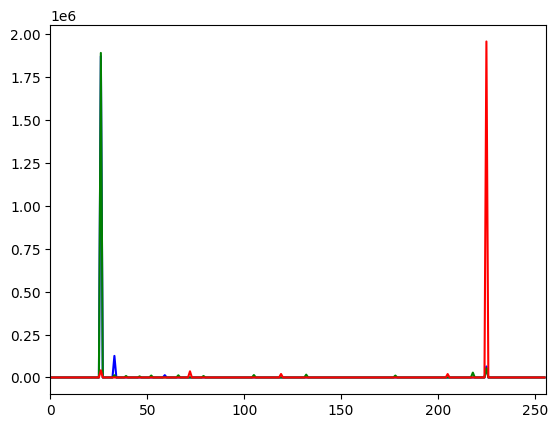

In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = images[len(images)//2]
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [25]:
import cv2
import numpy as np

# Function to generate motion heatmap and save it as a video
def save_motion_heatmap(video_path, output_path, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2):
    """
    Generates a motion heatmap from a video file using the Farneback optical flow method.

    Parameters:
        video_path (str): Path to the input video file.
        output_path (str): Path to save the output motion heatmap video.
        pyr_scale (float): Scale factor for building the image pyramid. Default is 0.5.
        levels (int): Number of pyramid layers. Default is 3.
        winsize (int): Size of the averaging window for each pyramid level. Default is 15.
        iterations (int): Number of iterations at each pyramid level. Default is 3.
        poly_n (int): Size of the pixel neighborhood used to find polynomial expansion in each pixel. Default is 5.
        poly_sigma (float): Standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion. Default is 1.2.
    """
    cap = cv2.VideoCapture(video_path)
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    # Get video frame properties
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, 0, fps, (frame_width, frame_height))

    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255

    while True:
        ret, frame2 = cap.read()
        if not ret:
            break
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags=0)

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        out.write(bgr)

        prvs = next

    # Release video capture and writer objects
    cap.release()
    out.release()

# Example usage with custom parameters
save_motion_heatmap('data/out1/video.avi', 
                    'data/output_motions_3.avi', 
                    pyr_scale=0.5, 
                    levels=5, 
                    winsize=10, 
                    iterations=5,
                    poly_n=7, 
                    poly_sigma=1.4)
